# EDA

## Importing the libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from skimage.io import imread
from collections import defaultdict
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [3]:
%matplotlib inline

In [50]:
def create_boxes(in_row):
    box_list = []
    for (start_x, start_y, end_x, end_y) in in_row['bbox']:
        box_list += [Rectangle((start_x, start_y), 
                         np.abs(end_x-start_x),
                         np.abs(end_y-start_y)
                         )]
    return box_list

## Directory of File

In [20]:
image_dir = "minideeplesion/"

## Importing and cleaning the dataset

In [9]:
df = pd.read_csv("DL_info.csv")

In [16]:
df.head()

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test
0,000001_01_01_109.png,1,1,1,109,"233.537, 95.0204, 234.057, 106.977, 231.169, 1...","226.169, 90.0204, 241.252, 111.977","11.9677, 5.10387","0.44666, 0.283794, 0.434454",3,0,"103, 115","0.488281, 0.488281, 5","512, 512","-175, 275",F,62.0,3
1,000001_02_01_014.png,1,2,1,14,"224.826, 289.296, 224.016, 305.294, 222.396, 2...","217.396, 284.296, 233.978, 310.294","16.019, 6.61971","0.431015, 0.485238, 0.340745",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3
2,000001_02_01_017.png,1,2,1,17,"272.323, 320.763, 246.522, 263.371, 234.412, 3...","229.412, 258.371, 285.221, 325.763","62.9245, 48.9929","0.492691, 0.503106, 0.351754",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3
3,000001_03_01_088.png,1,3,1,88,"257.759, 157.618, 260.018, 133.524, 251.735, 1...","246.735, 128.524, 270.288, 162.618","24.1998, 13.6123","0.498999, 0.278924, 0.452792",3,0,"58, 118","0.732422, 0.732422, 1","512, 512","-175, 275",F,73.0,3
4,000001_04_01_017.png,1,4,1,17,"304.019, 230.585, 292.217, 211.789, 304.456, 2...","287.217, 206.789, 309.456, 235.585","22.1937, 9.8065","0.572678, 0.42336, 0.445674",3,0,"11, 23","0.666016, 0.666016, 5","512, 512","-175, 275",F,73.0,3


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32735 entries, 0 to 32734
Data columns (total 18 columns):
File_name                     32735 non-null object
Patient_index                 32735 non-null int64
Study_index                   32735 non-null int64
Series_ID                     32735 non-null int64
Key_slice_index               32735 non-null int64
Measurement_coordinates       32735 non-null object
Bounding_boxes                32735 non-null object
Lesion_diameters_Pixel_       32735 non-null object
Normalized_lesion_location    32735 non-null object
Coarse_lesion_type            32735 non-null int64
Possibly_noisy                32735 non-null int64
Slice_range                   32735 non-null object
Spacing_mm_px_                32735 non-null object
Image_size                    32735 non-null object
DICOM_windows                 32735 non-null object
Patient_gender                32735 non-null object
Patient_age                   32734 non-null float64
Train_Val_Te

In [23]:
df['def_path'] = df.apply(lambda c_row: os.path.join(image_dir, '{Patient_index:06d}_{Study_index:02d}_{Series_ID:02d}'.format(**c_row),
                                                                        '{Key_slice_index:03d}.png'.format(**c_row)), 1)

In [26]:
# df.head()
print('Loaded', df.shape[0], 'cases')

Loaded 32735 cases


In [30]:
# Getting the boundaries
df['bbox'] = df['Bounding_boxes'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1, 4)))
df['norm_loc'] = df['Normalized_lesion_location'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Spacing_mm_px_'] = df['Spacing_mm_px_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Lesion_diameters_Pixel_'] = df['Lesion_diameters_Pixel_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Radius_x'] = df.apply(lambda x: x['Lesion_diameters_Pixel_'][0]*x['Spacing_mm_px_'][0], 1)]

In [33]:
lesion_type_dict = dict(enumerate('Bone,Abdomen,Mediastinum,Liver,Lung,Kidney,Soft tissue,Pelvis'.split(','), 1))

df['Coarse_lesion_name'] = df['Coarse_lesion_type'].map(lambda x: lesion_type_dict.get(x, 'Unknown'))
for i, ax in enumerate('xyz'):
    df[f'{ax}_loc'] = df['norm_loc'].map(lambda x: x[i])
print('Found', df.shape[0], 'patients with images')

Found 32735 patients with images


In [35]:
df.head(3)

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,...,Patient_age,Train_Val_Test,def_path,bbox,norm_loc,Radius_x,Coarse_lesion_name,x_loc,y_loc,z_loc
0,000001_01_01_109.png,1,1,1,109,"233.537, 95.0204, 234.057, 106.977, 231.169, 1...","226.169, 90.0204, 241.252, 111.977","[11.9677, 5.10387]","0.44666, 0.283794, 0.434454",3,...,62.0,3,minideeplesion/000001_01_01/109.png,"[[226.169, 90.0204, 241.252, 111.977]]","[0.44666, 0.283794, 0.434454]",5.843601,Mediastinum,0.446660,0.283794,0.434454
1,000001_02_01_014.png,1,2,1,14,"224.826, 289.296, 224.016, 305.294, 222.396, 2...","217.396, 284.296, 233.978, 310.294","[16.019, 6.61971]","0.431015, 0.485238, 0.340745",3,...,72.0,3,minideeplesion/000001_02_01/014.png,"[[217.396, 284.296, 233.978, 310.294]]","[0.431015, 0.485238, 0.340745]",5.037223,Mediastinum,0.431015,0.485238,0.340745
2,000001_02_01_017.png,1,2,1,17,"272.323, 320.763, 246.522, 263.371, 234.412, 3...","229.412, 258.371, 285.221, 325.763","[62.9245, 48.9929]","0.492691, 0.503106, 0.351754",3,...,72.0,3,minideeplesion/000001_02_01/017.png,"[[229.412, 258.371, 285.221, 325.763]]","[0.492691, 0.503106, 0.351754]",19.786798,Mediastinum,0.492691,0.503106,0.351754


## EDA

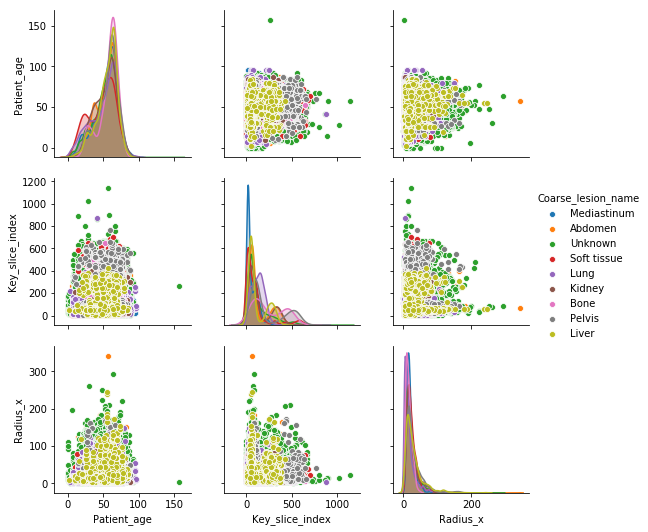

In [38]:
sns.pairplot(hue='Coarse_lesion_name', 
             data = df[['Patient_age', 'Coarse_lesion_name', 'Key_slice_index', 'Radius_x']])

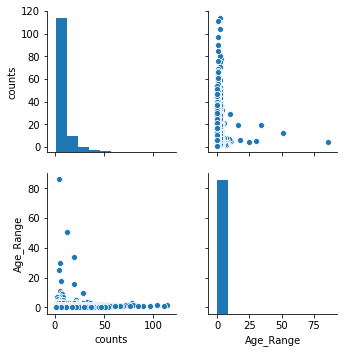

In [39]:
freq_flyers_df = df.groupby('Patient_index')[['Patient_age']].apply(
    lambda x: pd.Series({'counts': x.shape[0], 
                         'Age_Range': np.max(x['Patient_age'])-np.min(x['Patient_age'])})).reset_index().sort_values('Age_Range', ascending = False)
sns.pairplot(freq_flyers_df[['counts', 'Age_Range']])


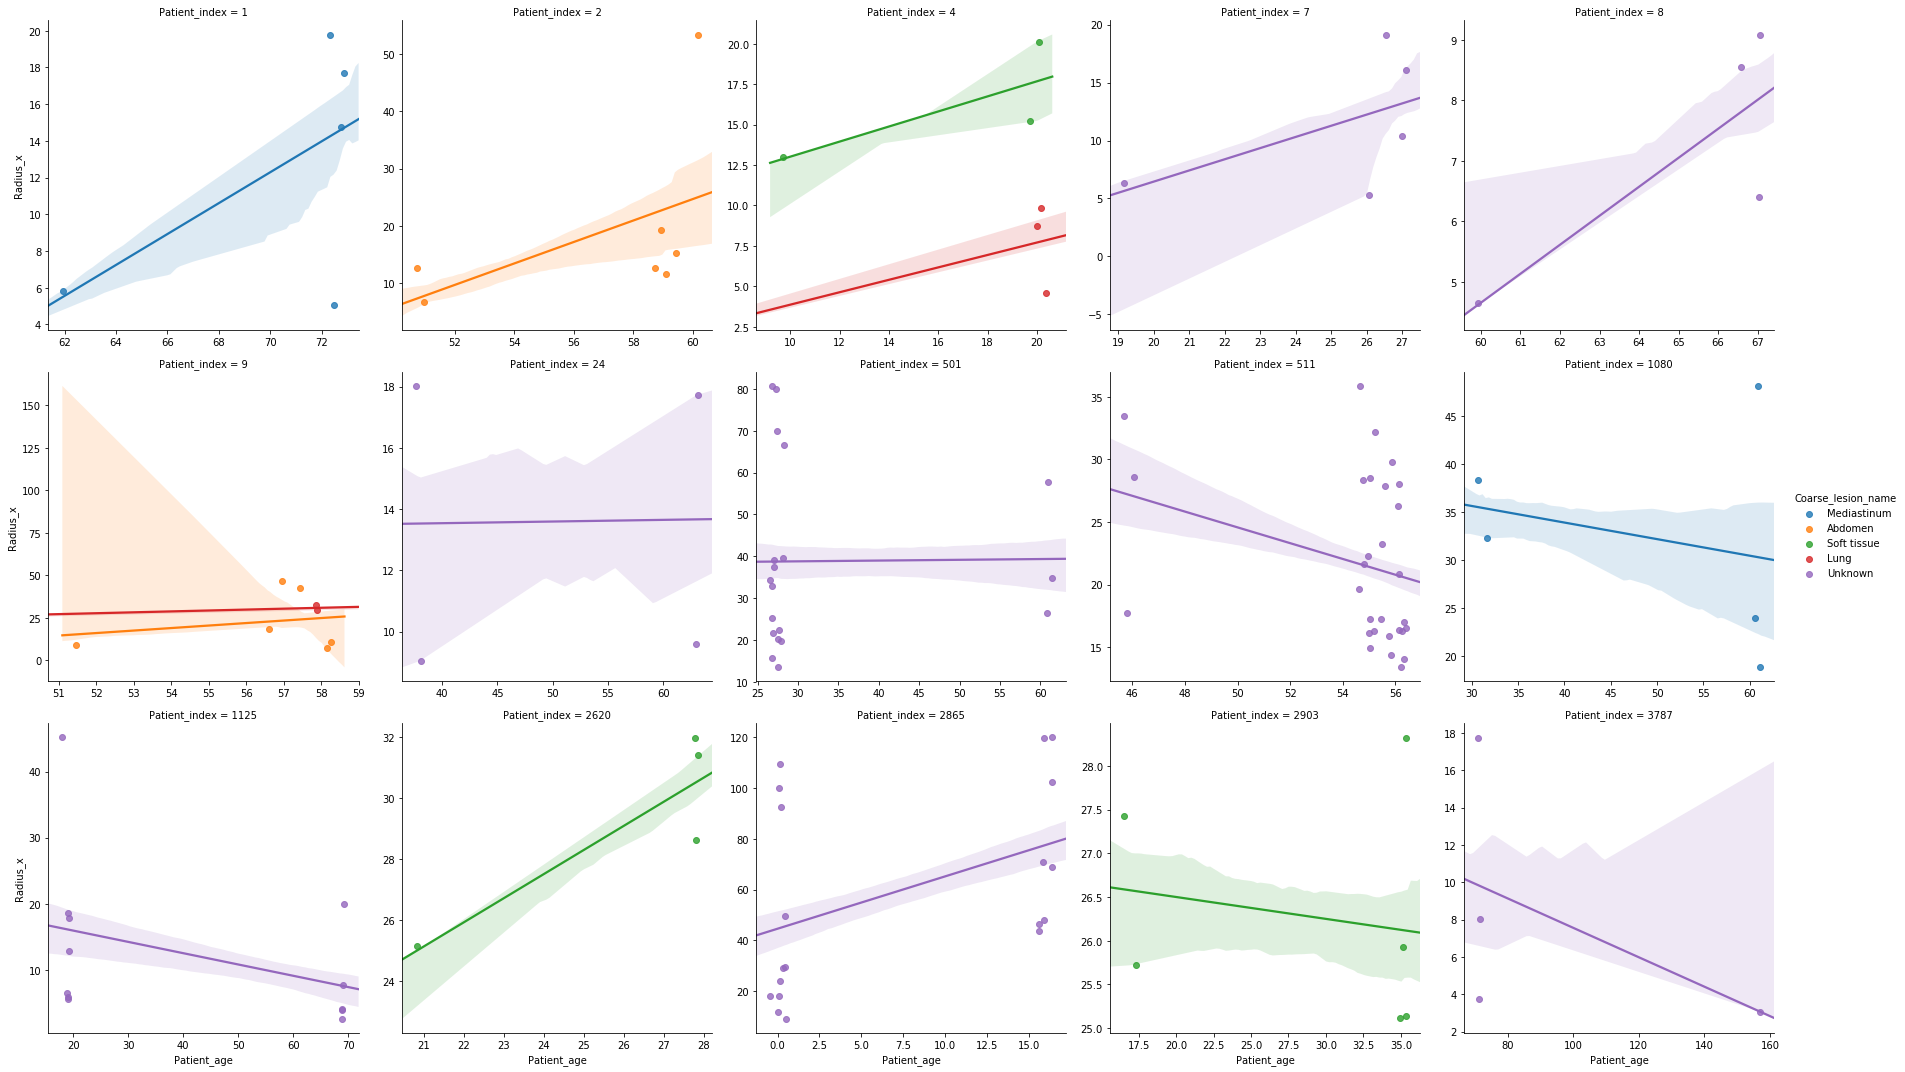

In [40]:
join_df = pd.merge(df, freq_flyers_df.head(15))
ax = sns.lmplot(x='Patient_age', y='Radius_x', ci=50,
                hue = 'Coarse_lesion_name',
                sharex=False, sharey=False, x_jitter=0.5,
                 col='Patient_index', col_wrap=5,
                data = join_df)

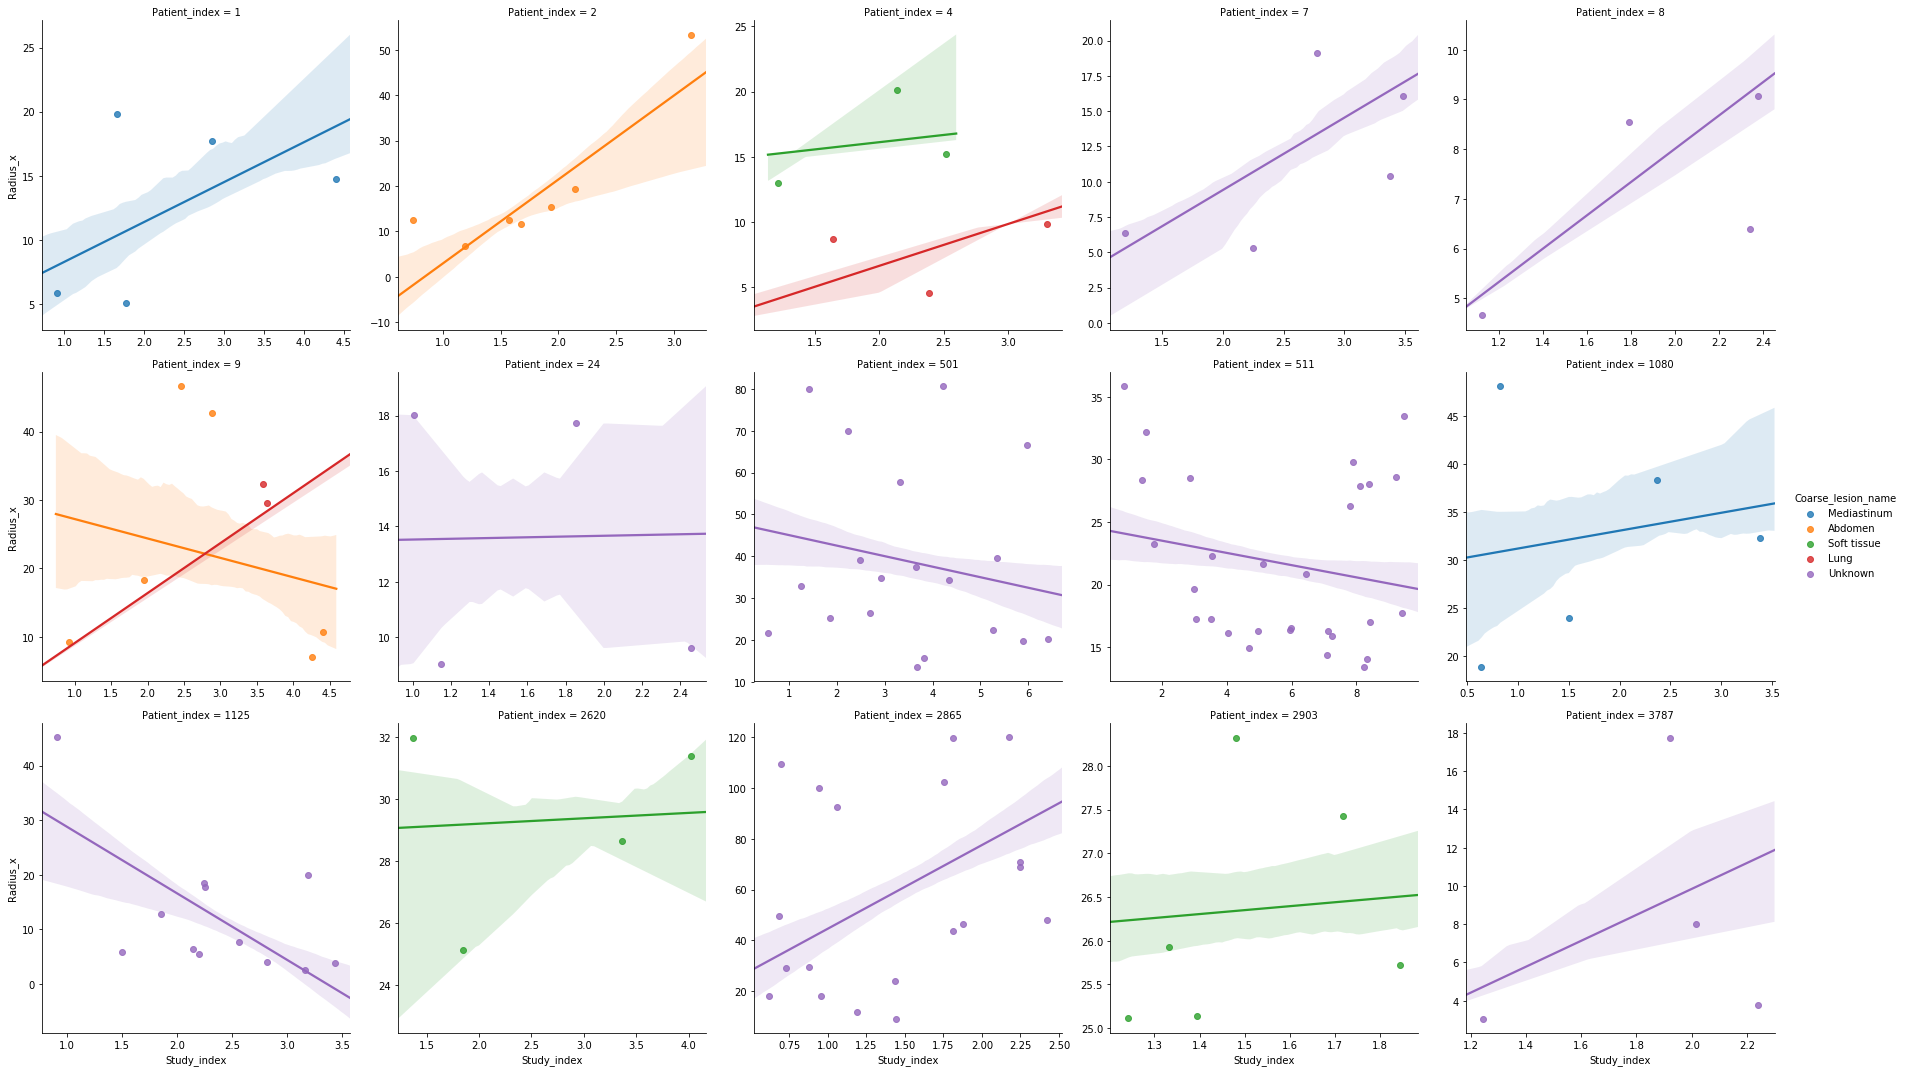

In [41]:
sns.lmplot(x='Study_index', y='Radius_x', ci=50,
                hue = 'Coarse_lesion_name',
                sharex=False, sharey=False, x_jitter=0.5,
                 col='Patient_index', col_wrap=5,
                data = join_df)

In [43]:
def count_and_check_studies(in_patient_df):
    gr_df = in_patient_df.groupby('Study_index').size().reset_index(name='counts')
    match_df = gr_df[gr_df['counts']==gr_df['counts'].max()]
    
    if (gr_df['counts'].max()>1) and (match_df.shape[0]>1): # more than one study and more than one series 
        return in_patient_df[in_patient_df['Study_index'].isin(match_df['Study_index'])]
    else:
        return in_patient_df.head(0)
grp_patient_df = df.groupby(['Patient_index']).apply(count_and_check_studies).reset_index(drop = True)
print(grp_patient_df.shape[0], 'scans available')
print(len(grp_patient_df['Patient_index'].value_counts()), 'patients')
print(len(grp_patient_df.groupby(['Patient_index', 'Study_index'])), 'studies')
grp_patient_df.head(5)

3313 scans available
419 patients
962 studies


,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,...,Patient_age,Train_Val_Test,def_path,bbox,norm_loc,Radius_x,Coarse_lesion_name,x_loc,y_loc,z_loc
0,000016_01_01_008.png,16,1,1,8,"262.222, 214.222, 286.222, 214.222, 274.667, 2...","257.222, 200.333, 291.222, 231.667","[24.0, 21.3518]","0.541926, 0.350768, 0.578449",4,...,54.0,3,minideeplesion/000016_01_01/008.png,"[[257.222, 200.333, 291.222, 231.667]]","[0.541926, 0.350768, 0.578449]",16.875000,Liver,0.541926,0.350768,0.578449
1,000016_01_01_030.png,16,1,1,30,"360, 359.111, 331.556, 345.778, 350.222, 344, ...","326.556, 339, 365, 364.111","[31.4144, 15.5238]","0.682724, 0.63216, 0.687355",6,...,54.0,3,minideeplesion/000016_01_01/030.png,"[[326.556, 339.0, 365.0, 364.111]]","[0.682724, 0.63216, 0.687355]",22.088250,Kidney,0.682724,0.632160,0.687355
2,000016_01_01_030.png,16,1,1,30,"146.667, 307.556, 104.889, 339.556, 131.556, 3...","99.8889, 302.556, 151.667, 355.222","[52.6249, 48.9535]","0.221222, 0.586175, 0.687355",6,...,54.0,3,minideeplesion/000016_01_01/030.png,"[[99.8889, 302.556, 151.667, 355.222]]","[0.221222, 0.586175, 0.687355]",37.001883,Kidney,0.221222,0.586175,0.687355
3,000016_01_01_025.png,16,1,1,25,"172.444, 358.222, 125.333, 340.444, 144.889, 3...","120.333, 331, 177.444, 370.333","[50.3538, 31.5274]","0.254966, 0.628073, 0.670661",6,...,54.0,3,minideeplesion/000016_01_01/025.png,"[[120.333, 331.0, 177.444, 370.333]]","[0.254966, 0.628073, 0.670661]",35.405016,Kidney,0.254966,0.628073,0.670661
4,000016_02_01_253.png,16,2,1,253,"263.656, 204.963, 284.07, 204.113, 273.012, 21...","258.656, 190.607, 289.07, 218.469","[20.4324, 17.8831]","0.524361, 0.344255, 0.579124",4,...,59.0,3,minideeplesion/000016_02_01/253.png,"[[258.656, 190.607, 289.07, 218.469]]","[0.524361, 0.344255, 0.579124]",16.754568,Liver,0.524361,0.344255,0.579124
